In [1]:
from Data.weatherbench_128_v2 import WeatherBench128
from Models.imvp_v2 import IAM4VP
from utils.metrics import Metrics

/home/fa.buzaev/.conda/envs/my_py_env1/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import torch
import numpy as np
import xarray as xr
import torch
from torch import nn, einsum
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_start_time = '2000-01-01 00:00:00'
train_end_time = '2003-12-25 00:00:00' # '2000-01-01 23:00:00' #
val_start_time = '2004-01-01 00:00:00'
val_end_time = '2004-12-25 00:00:00' # '2004-01-01 23:00:00' #

train_data = WeatherBench128(start_time=train_start_time, end_time=train_end_time,
                            include_target=False, 
                            lead_time=1, 
                            interval=1,
                            muti_target_steps=1,
                            start_time_x=0,
                            end_time_x=11,      
                            start_time_y=12,
                            end_time_y=85)  
train_loader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=4)

In [6]:
mean = train_data.data_mean_tensor
std = train_data.data_std_tensor

In [7]:
x_train, y_train = next(iter(train_loader))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
model = IAM4VP().to(device)

In [10]:
pretrained_weights = torch.load(f"/home/fa.buzaev/checkpoints/train_imvp/2025-04-10-10:24jwdrd/epoch=00-val_loss=0.1577.ckpt", map_location=device)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
model = model.to(device)

In [11]:
model

IAM4VP(
  (time_mlp): Time_MLP(
    (sinusoidaposemb): SinusoidalPosEmb()
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (gelu): GELU(approximate='none')
    (linear2): Linear(in_features=256, out_features=64, bias=True)
  )
  (enc): Encoder(
    (enc): Sequential(
      (0): CircularConvSC(
        (conv): CircularBasicConv2d(
          (conv): CircularConv2d(
            (conv): Conv2d(69, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm): LayerNorm()
          (act): SiLU(inplace=True)
        )
      )
      (1): CircularConvSC(
        (conv): CircularBasicConv2d(
          (conv): CircularConv2d(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
          (norm): LayerNorm()
          (act): SiLU(inplace=True)
        )
      )
      (2): CircularConvSC(
        (conv): CircularBasicConv2d(
          (conv): CircularConv2d(
            (conv): Conv2d(64, 64, kernel_size=(3, 3

In [15]:
def prepare_data(data):
    # data = data[:, ::-1] # Надо отзеркалить тут

    shapes = [*data.shape]
    rows, cols = shapes[-2], shapes[-1]
    
    shift = cols // 2

    shifted_array = np.roll(data, shift, axis=-1)

    # return denorm(data, std, mean)
    return shifted_array

In [16]:
def denorm(item, std, mean):
    mean = mean.squeeze()
    std = std.squeeze()
    item_denorm = item * std + mean
    return item_denorm

In [17]:
from IPython.display import clear_output

In [26]:
# x_test, y_test = x_train[:1, :6], y_train[:1, :6]
x_test, y_test = x_train[:1, :6], x_train[:1, 6:]

x_test, y_test = x_test.to(device), y_test.to(device)

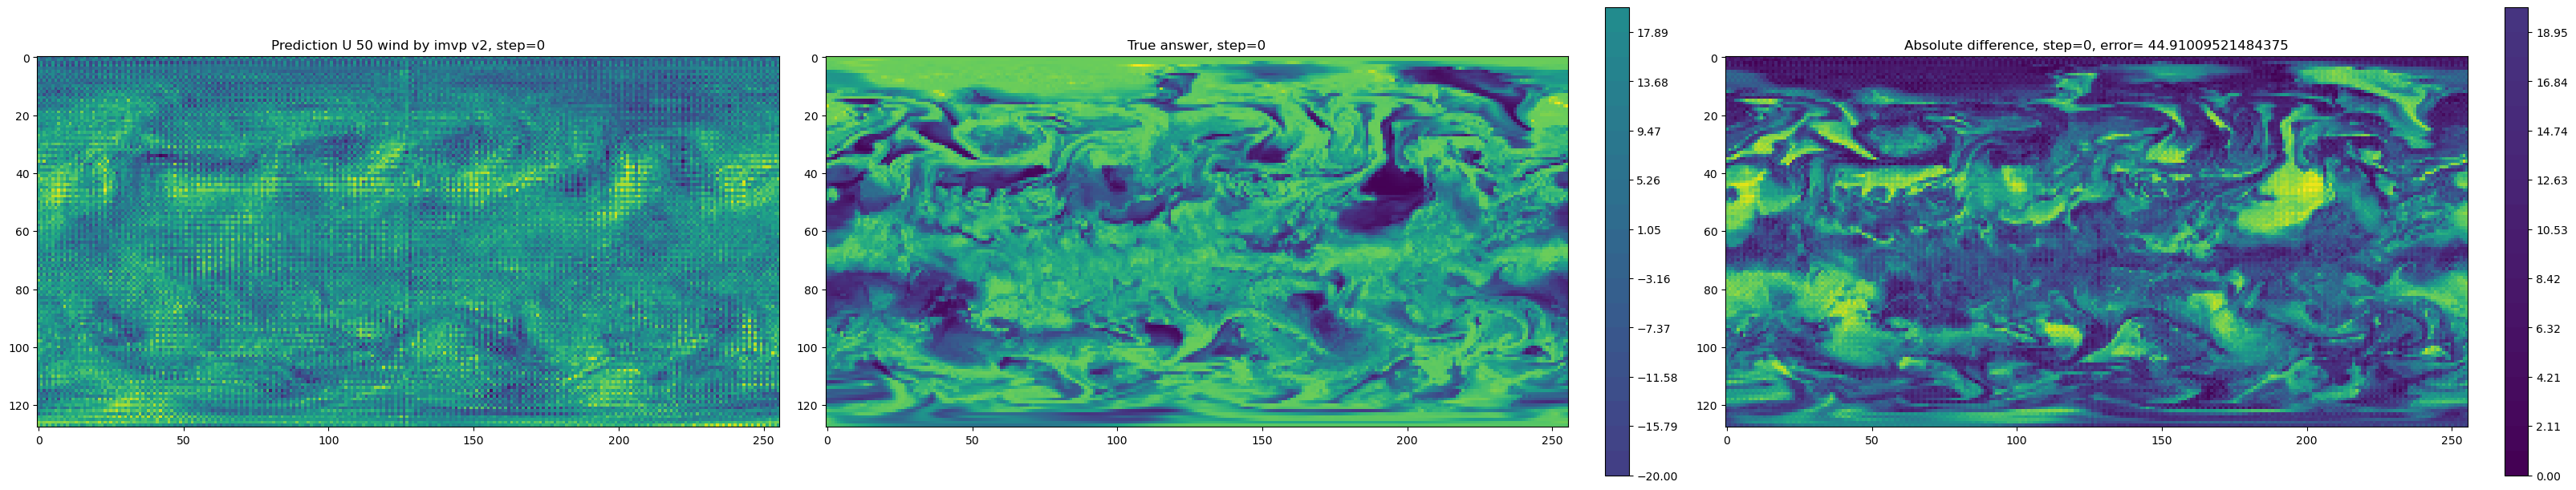

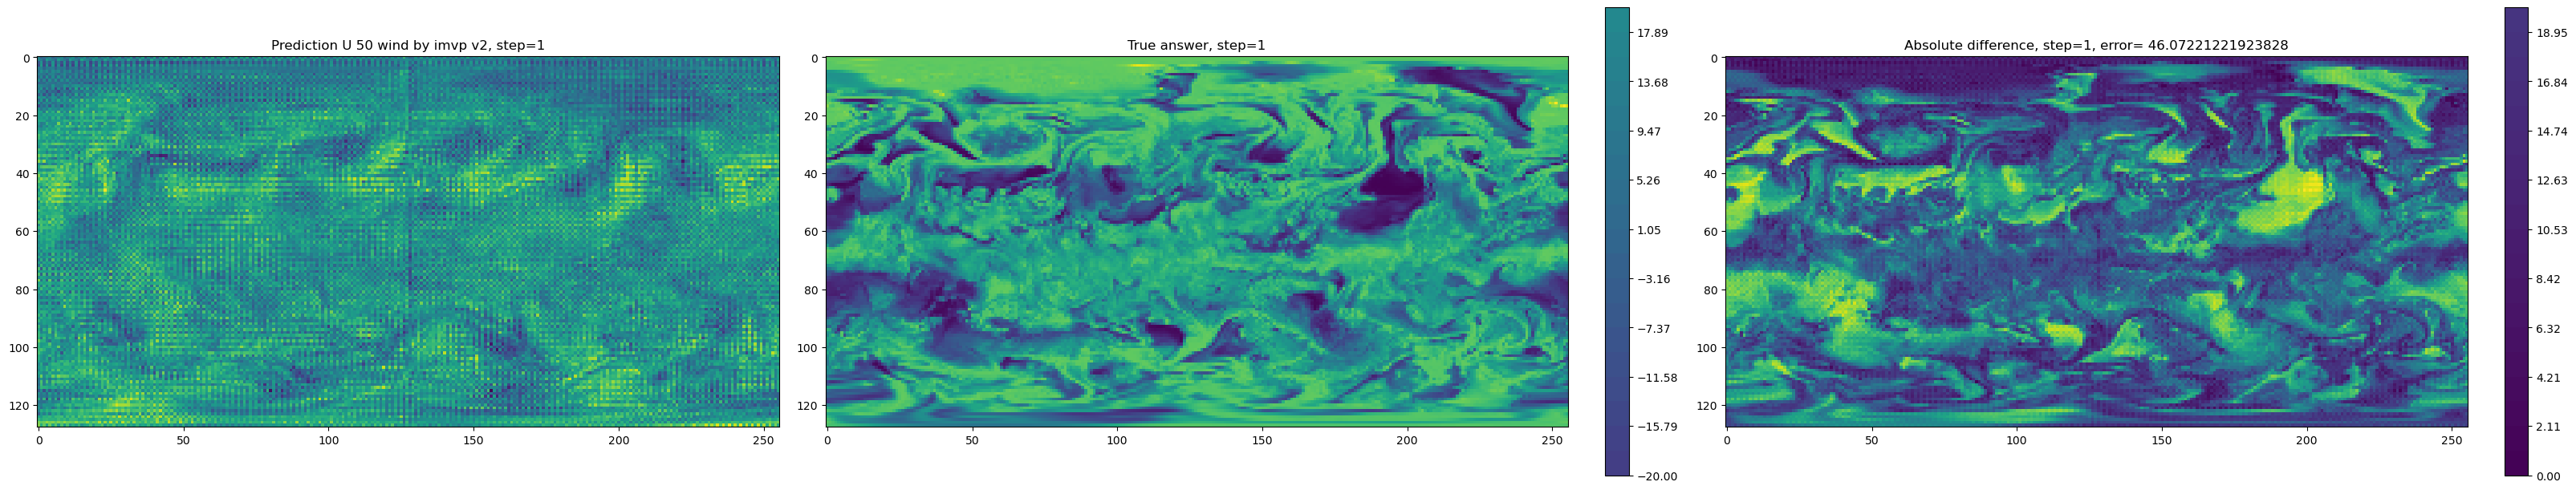

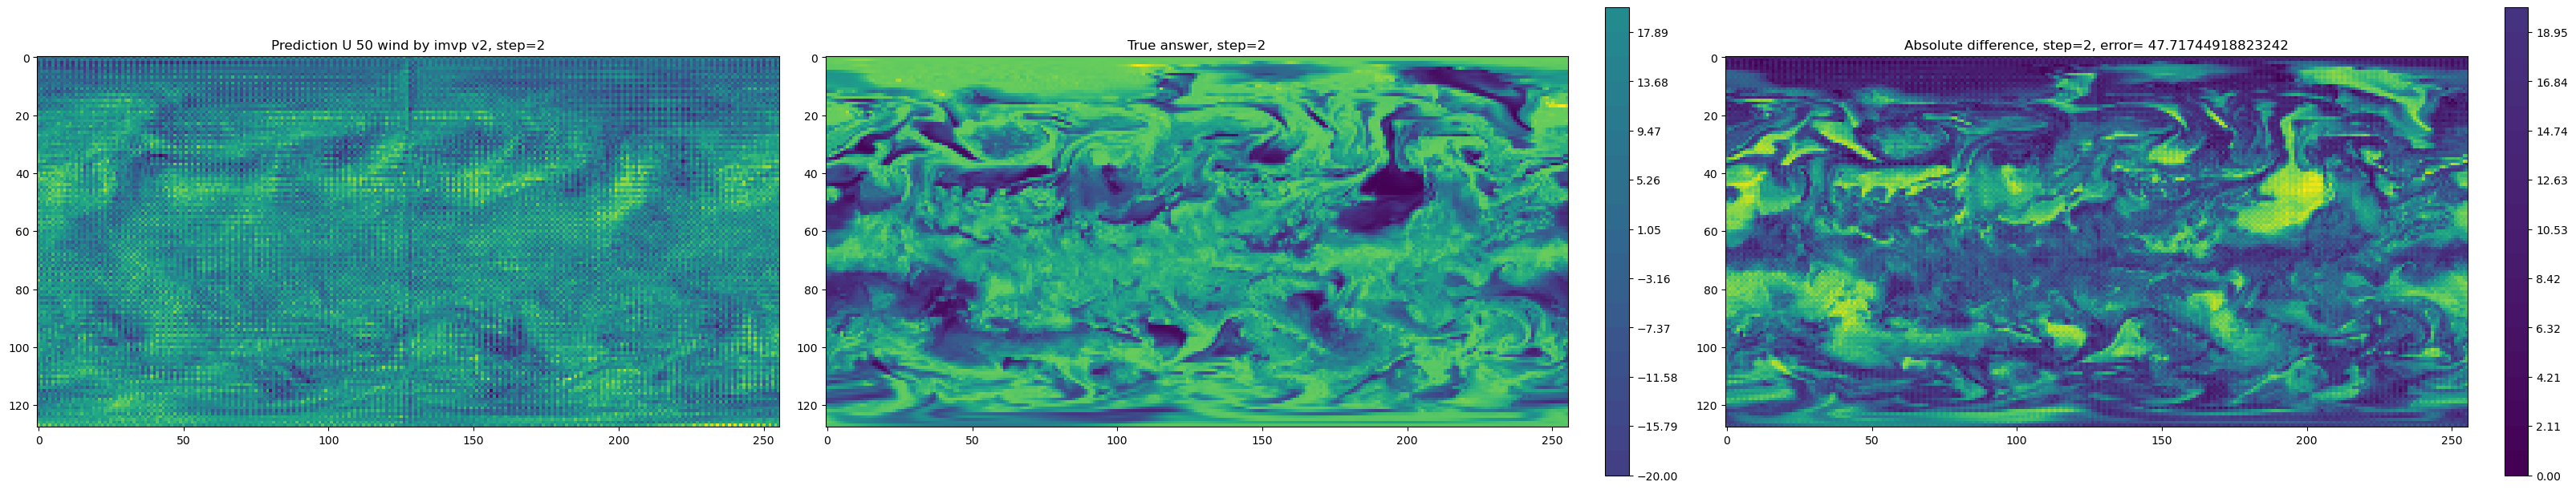

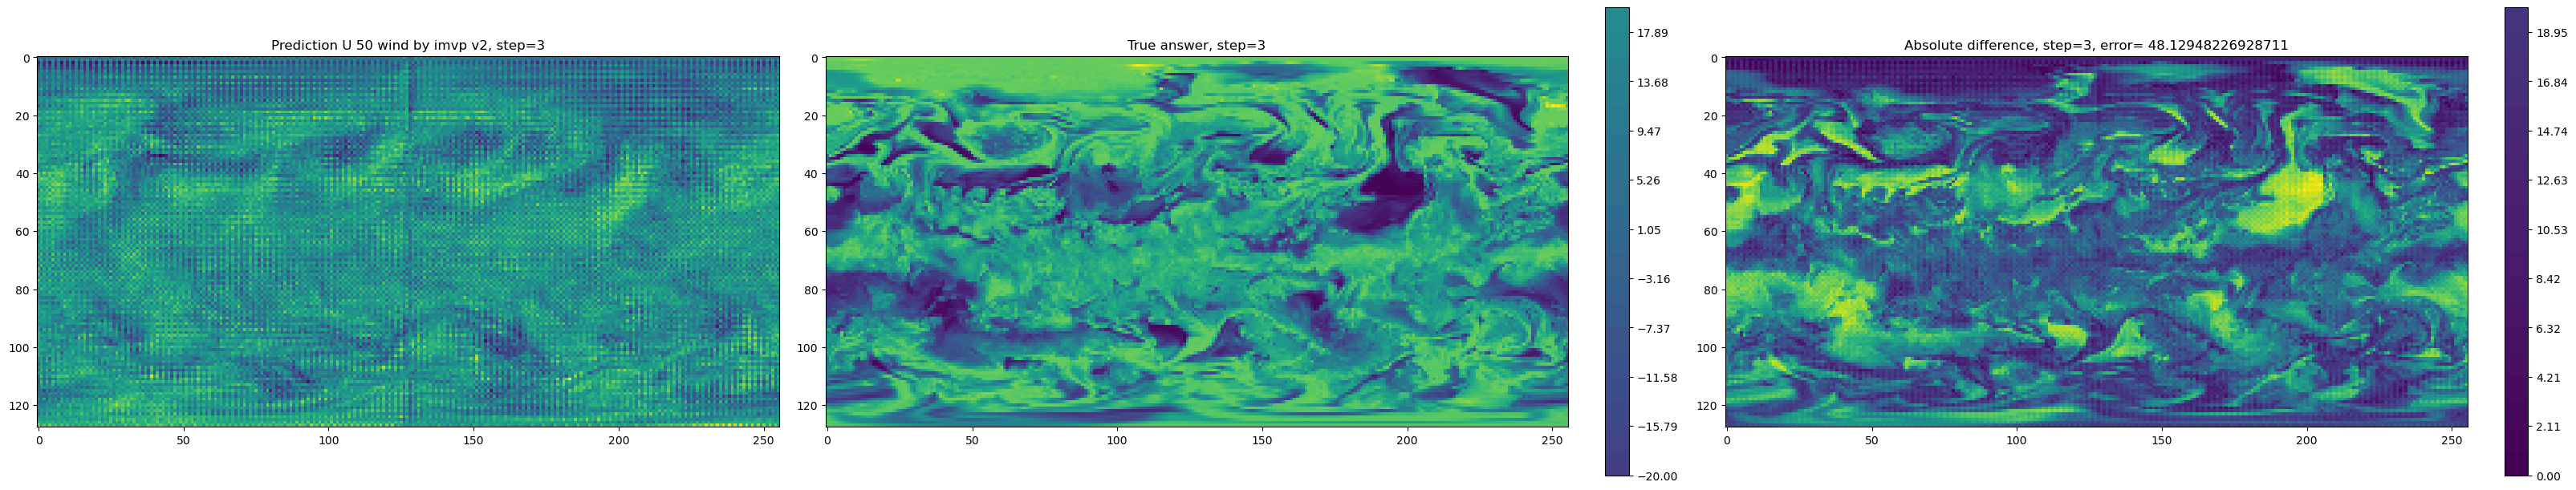

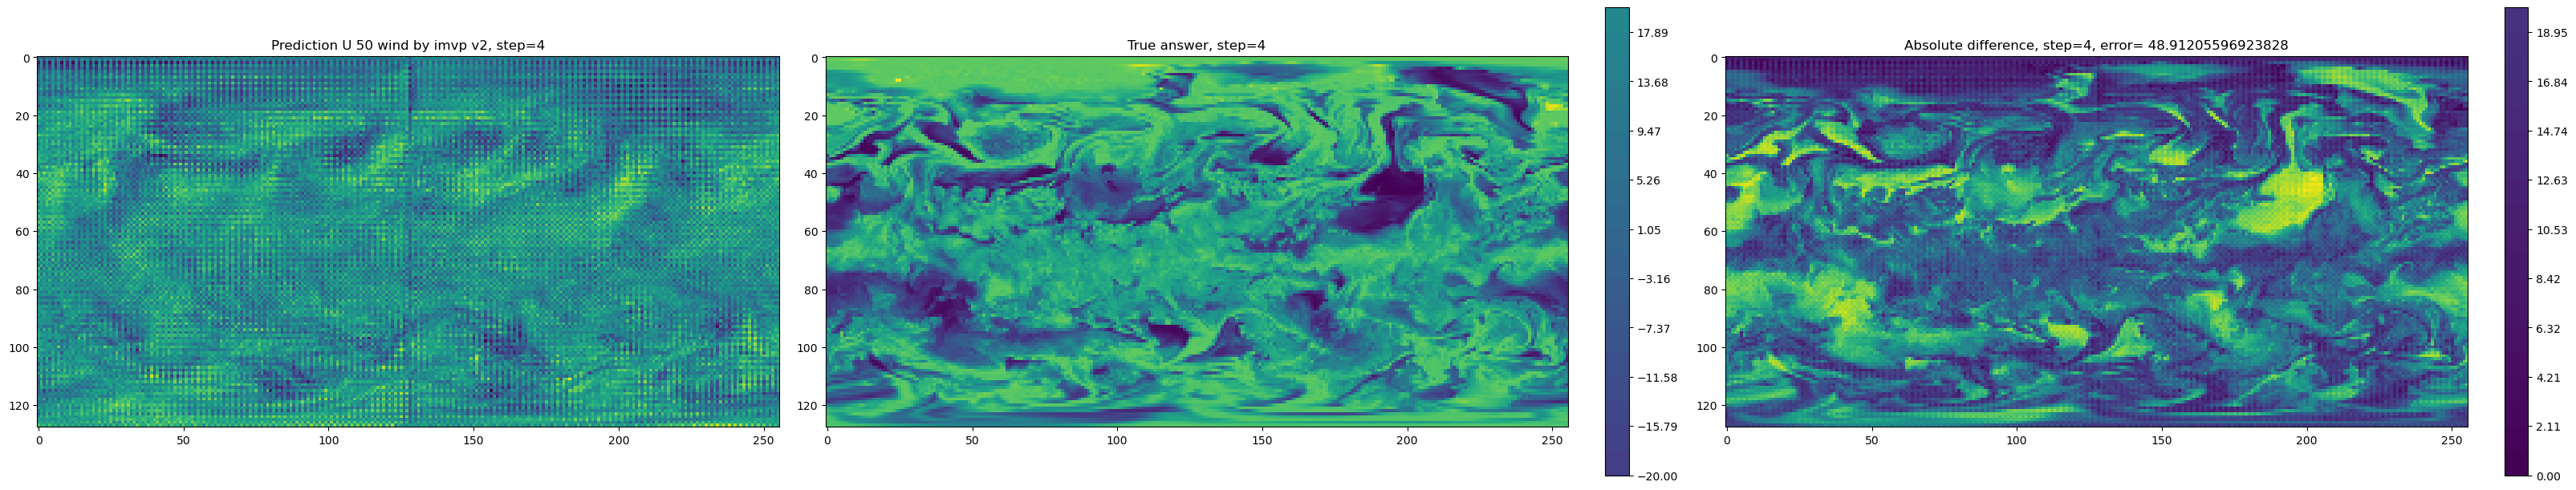

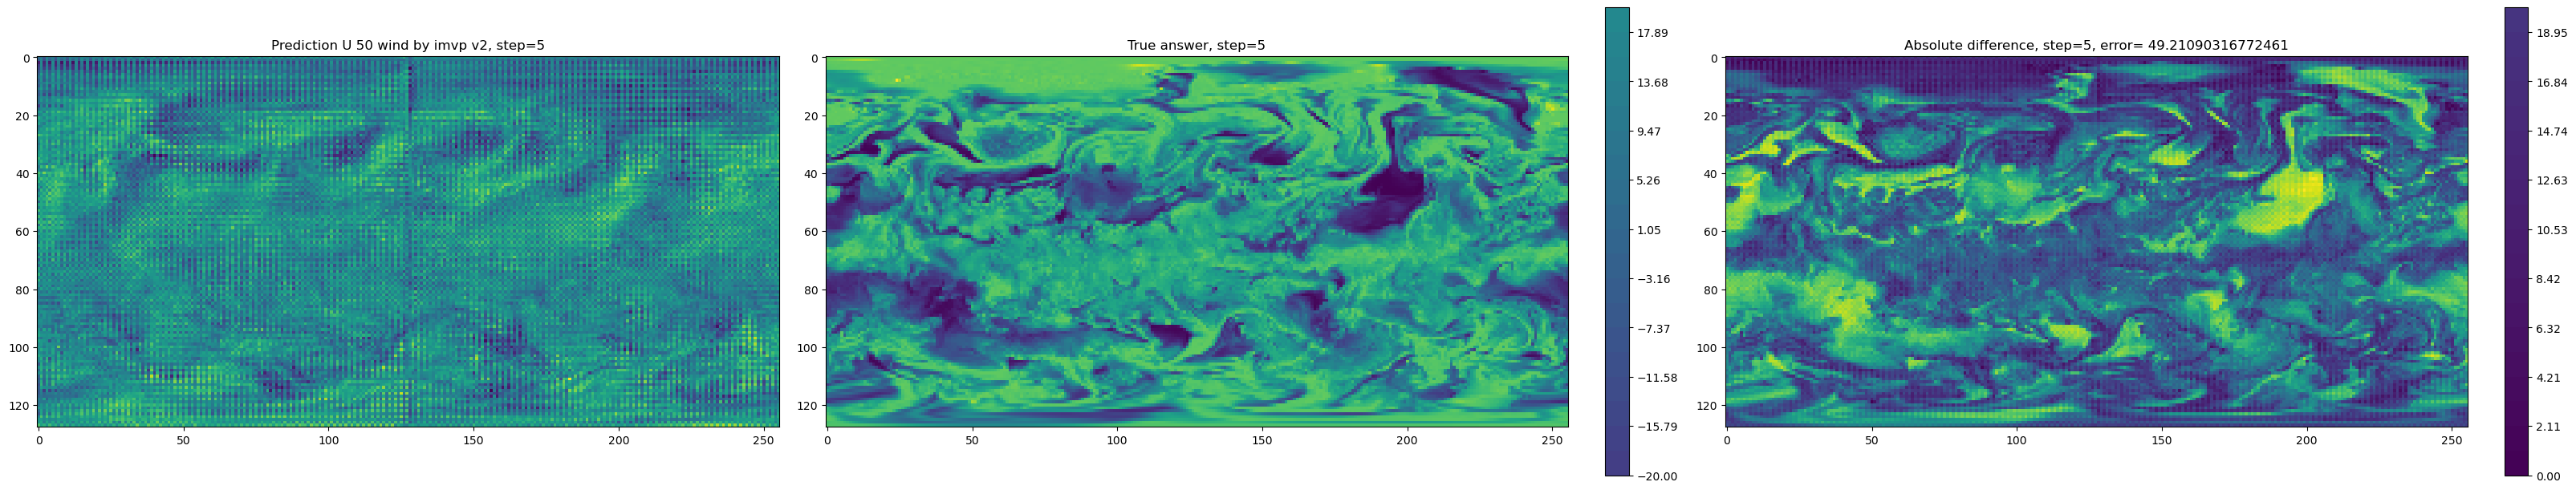

In [27]:
t = 0
x_data = x_test

for i in range(1):
    pred_list = []
    x_test_ = torch.empty(x_test.shape, device=device)
    for j in range(6):

        time_tensor = torch.tensor((j + 1) * 100).repeat(x_test.shape[0]).to(device)
        with torch.no_grad():
            prediction = model(x_data, pred_list, time_tensor)

        x_test_[:, j] = prediction
        pred_list.append(prediction.detach().to(device))
        
        z_0, t_0, q_0, u_0, v_0 = prediction[:, 4:].chunk(5, dim=1)

        plt.figure(constrained_layout=True, figsize=(32, 6))

        plt.subplot(131)
        plt.imshow(denorm(u_0[0, 0], std[40], mean[40]).squeeze().detach().cpu().numpy())
        plt.title(f"Prediction U 50 wind by imvp v2, step={t}")
        # plt.colorbar()

        plt.subplot(132)
        plt.imshow(denorm(y_test[0, t, 40], std[40], std[40]).squeeze().detach().cpu().numpy())
        plt.title(f"True answer, step={t}")
        plt.colorbar(boundaries=np.linspace(-20, 20, 20))

        plt.subplot(133)
        diff = denorm(u_0[0, 0], std[40], mean[40]).squeeze().detach().cpu().numpy() - denorm(y_test[0, t, 40], std[40], std[40]).squeeze().detach().cpu().numpy()
        plt.imshow(np.abs(diff))
        plt.title(f"Absolute difference, step={t}, error= {np.abs(np.mean(diff))}")
        plt.colorbar(boundaries=np.linspace(0, 20, 20))
        clear_output(wait=True)

        plt.savefig(f"predictions/imvp_v2_{t}.png")
        clear_output()

        t += 1
    x_data = x_test_

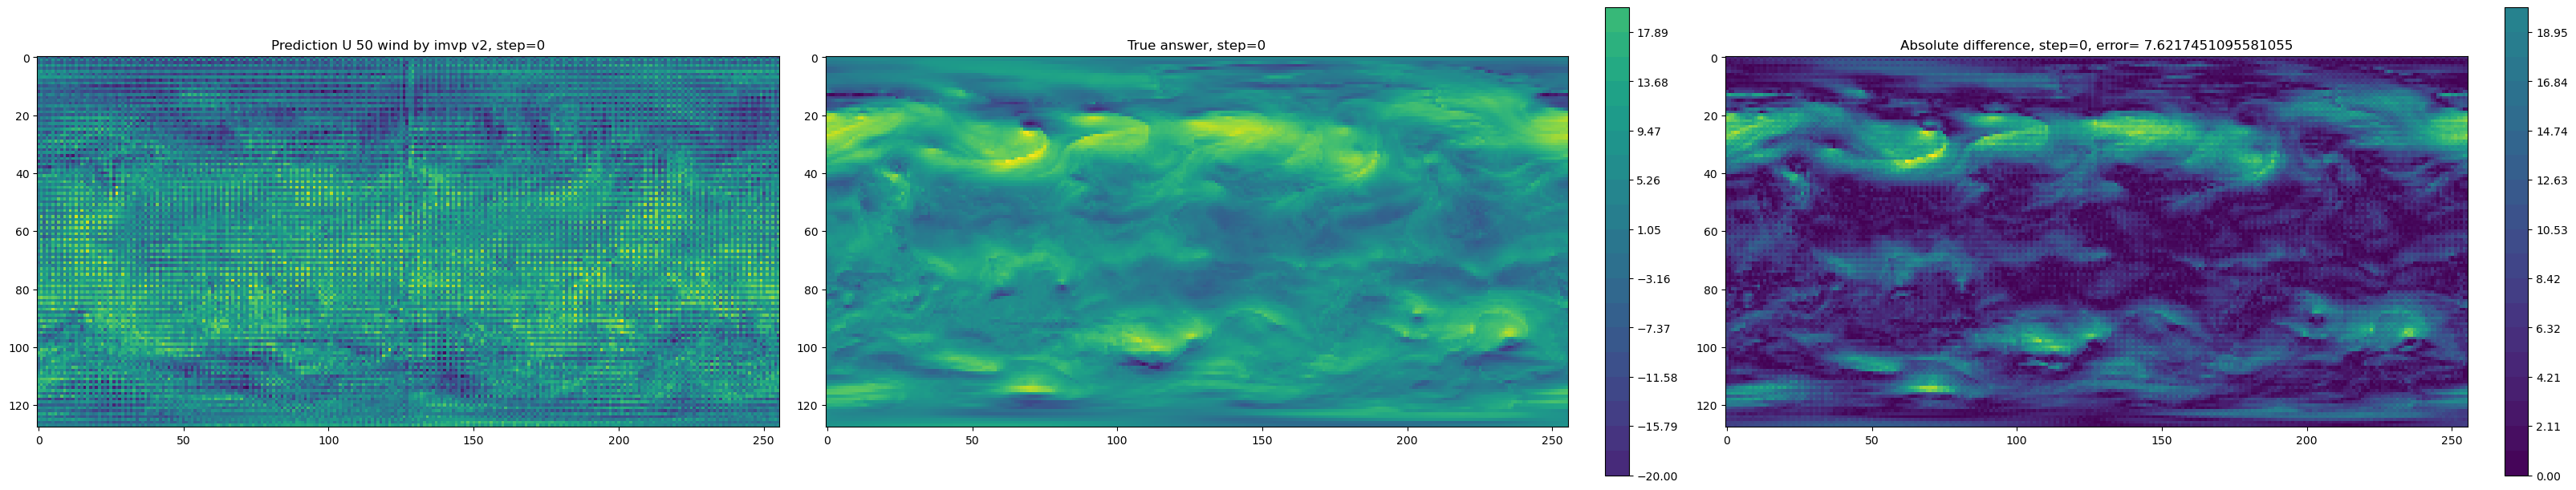

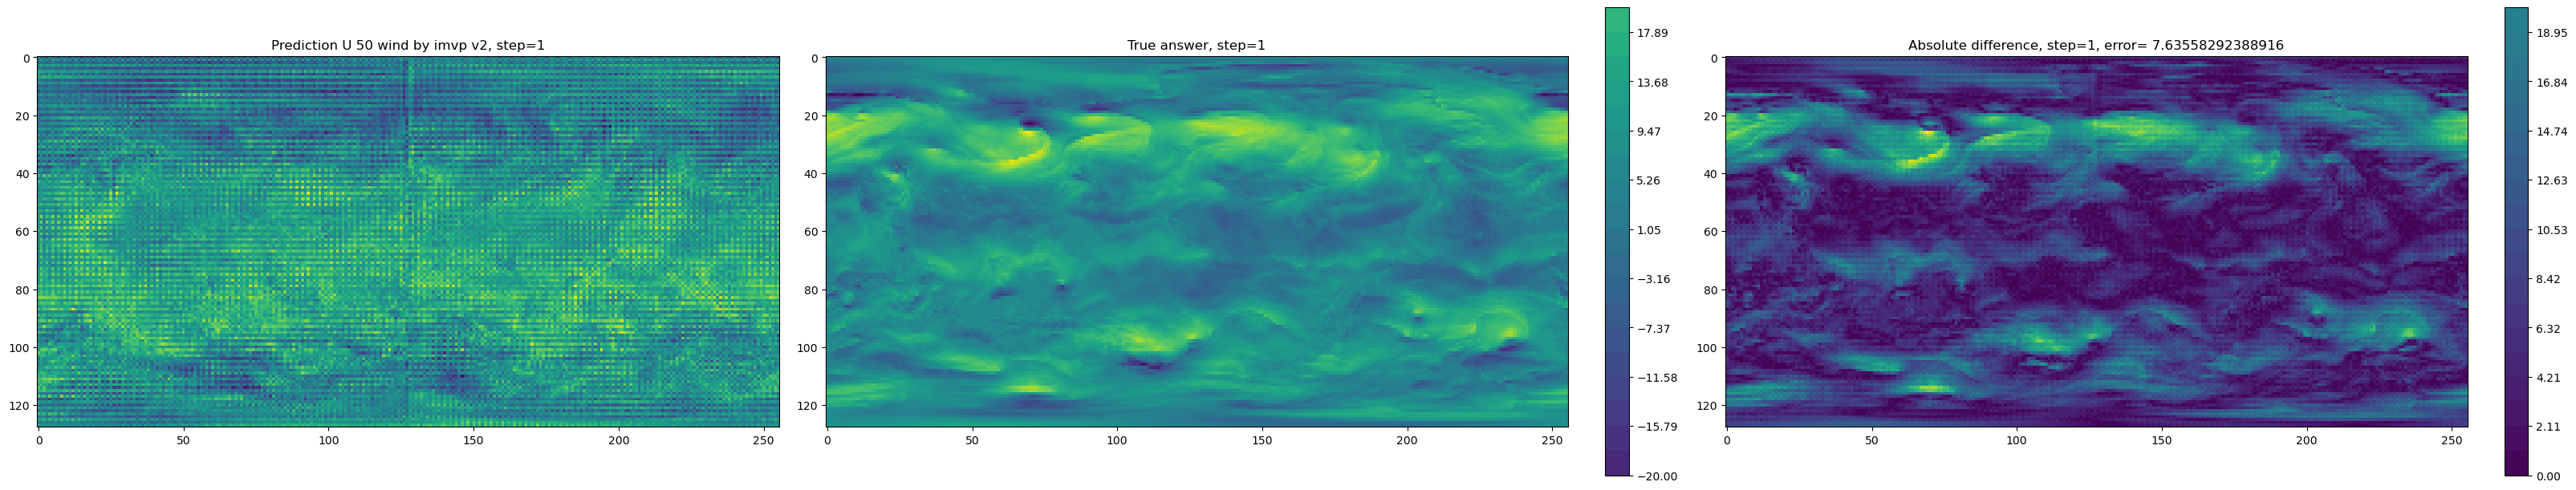

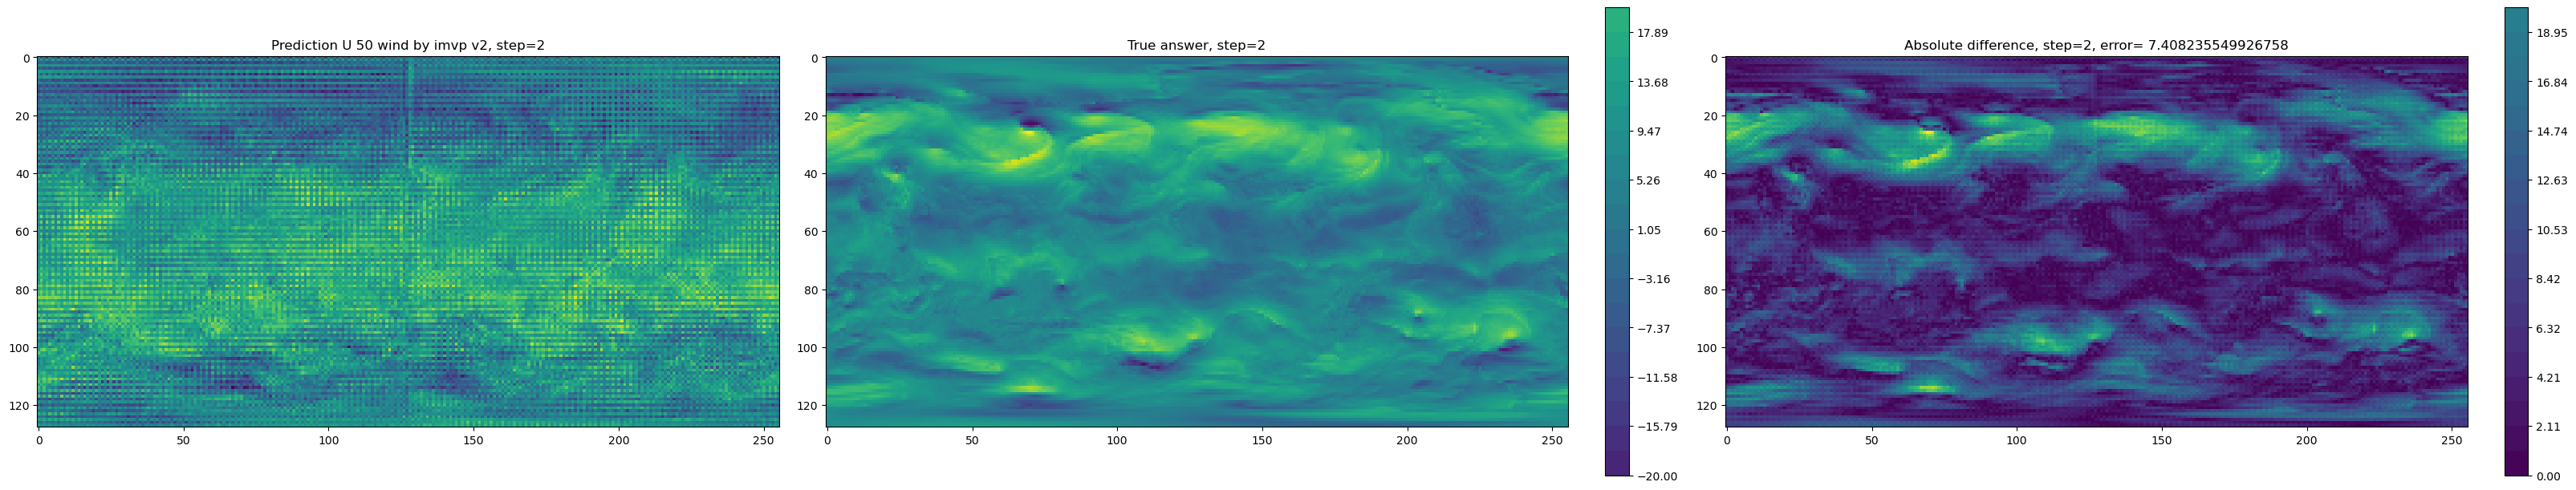

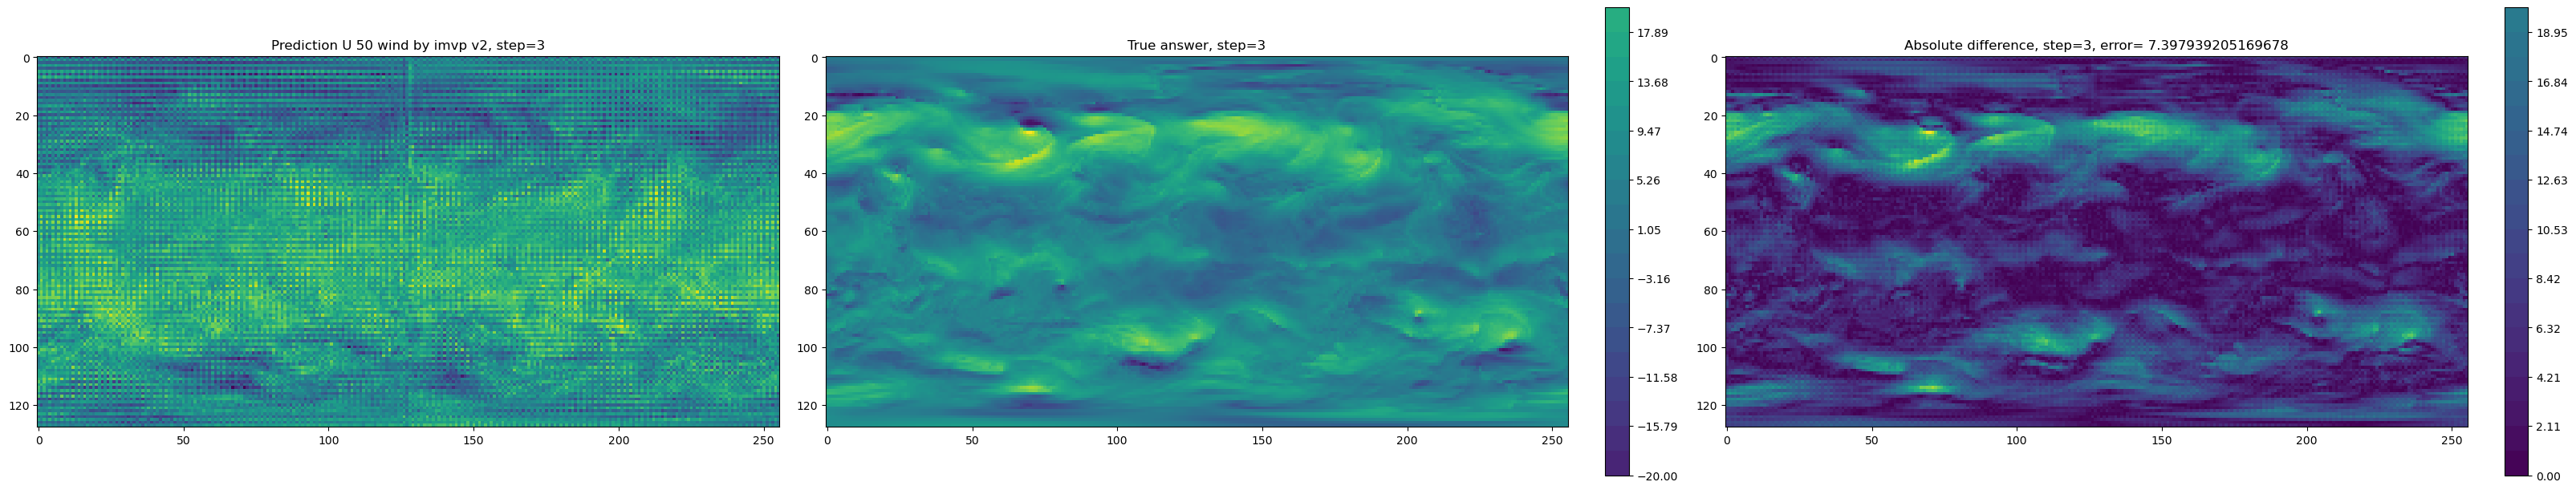

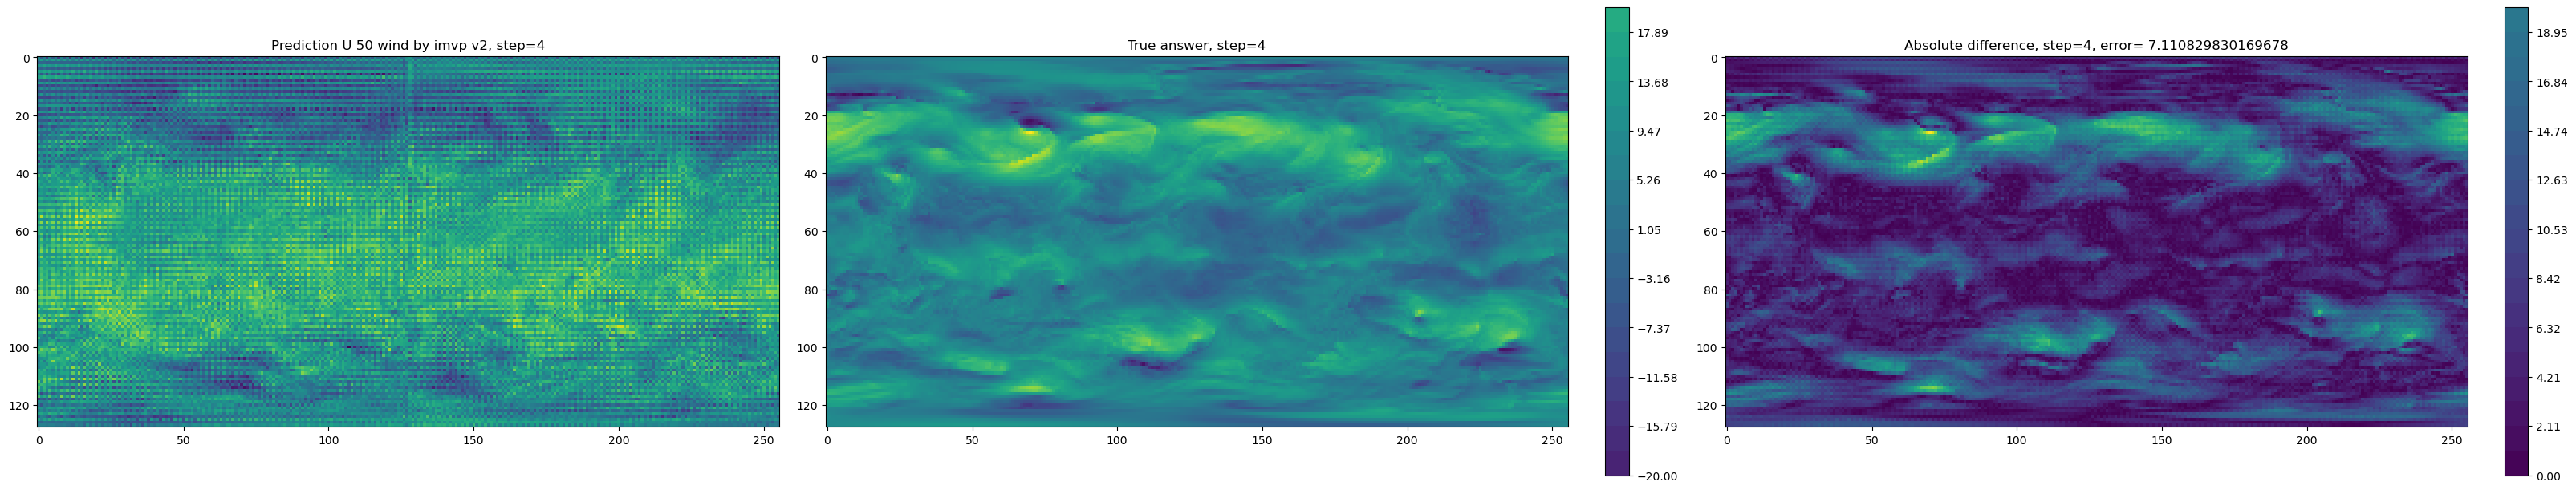

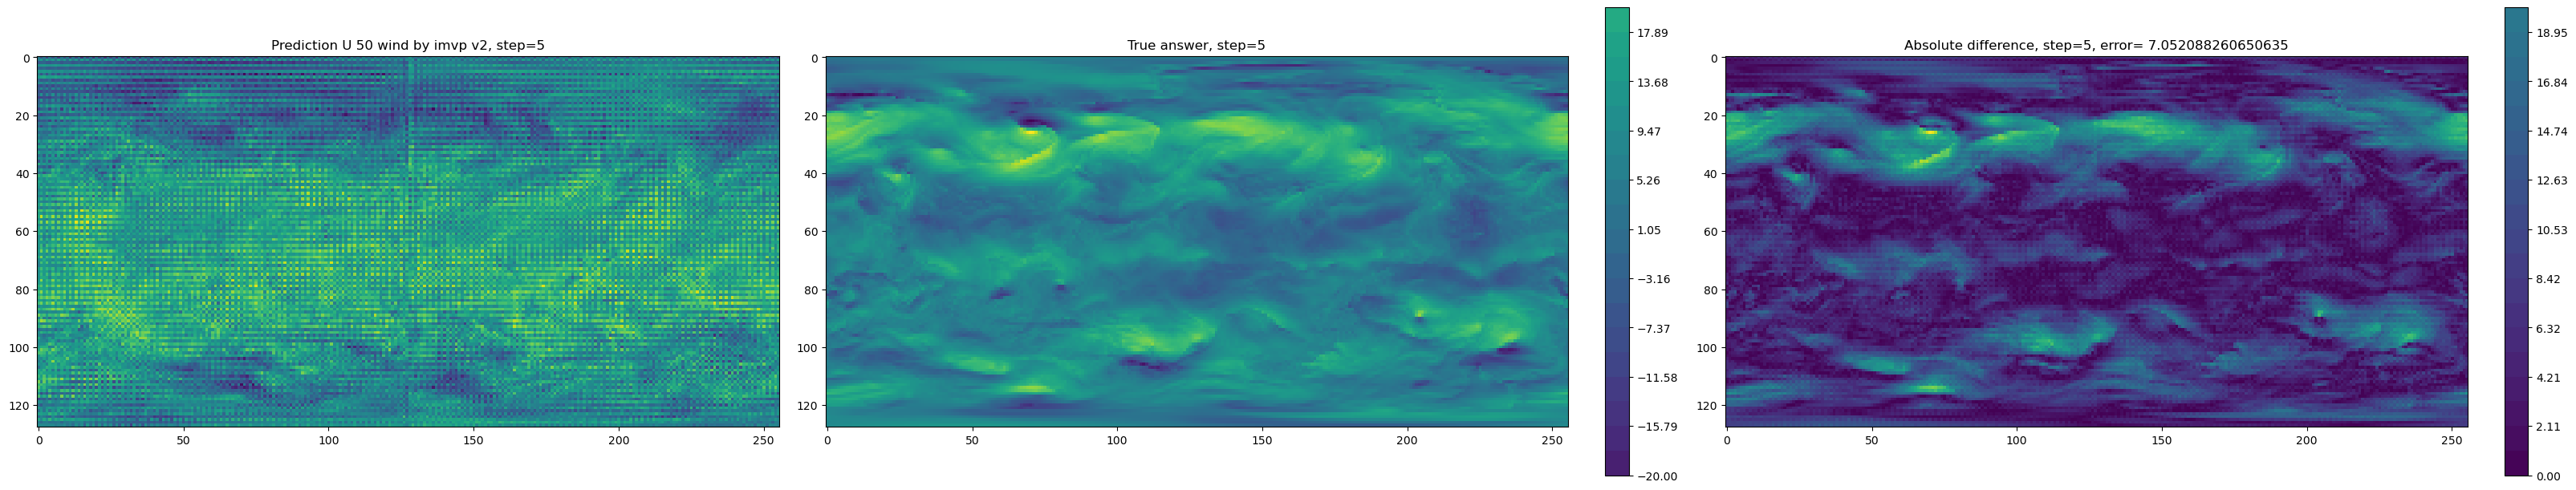

In [30]:
t = 0
x_data = x_test

for i in range(1):
    pred_list = []
    x_test_ = torch.empty(x_test.shape, device=device)
    for j in range(6):

        time_tensor = torch.tensor((j + 1) * 100).repeat(x_test.shape[0]).to(device)
        with torch.no_grad():
            prediction = model(x_data, pred_list, time_tensor)

        x_test_[:, j] = prediction
        pred_list.append(prediction.detach().to(device))
        
        z_0, t_0, q_0, u_0, v_0 = prediction[:, 4:].chunk(5, dim=1)

        plt.figure(constrained_layout=True, figsize=(32, 6))

        plt.subplot(131)
        plt.imshow(denorm(v_0[0, 0], std[53], mean[53]).squeeze().detach().cpu().numpy())
        plt.title(f"Prediction U 50 wind by imvp v2, step={t}")
        # plt.colorbar()

        plt.subplot(132)
        plt.imshow(denorm(y_test[0, t, 53], std[53], std[53]).squeeze().detach().cpu().numpy())
        plt.title(f"True answer, step={t}")
        plt.colorbar(boundaries=np.linspace(-20, 20, 20))

        plt.subplot(133)
        diff = denorm(v_0[0, 0], std[53], mean[53]).squeeze().detach().cpu().numpy() - denorm(y_test[0, t, 53], std[53], std[53]).squeeze().detach().cpu().numpy()
        plt.imshow(np.abs(diff))
        plt.title(f"Absolute difference, step={t}, error= {np.abs(np.mean(diff))}")
        plt.colorbar(boundaries=np.linspace(0, 20, 20))
        clear_output(wait=True)

        plt.savefig(f"predictions/imvp_v2_{t}.png")
        clear_output()

        t += 1
    x_data = x_test_

In [33]:
x_train.shape

torch.Size([2, 12, 69, 128, 256])

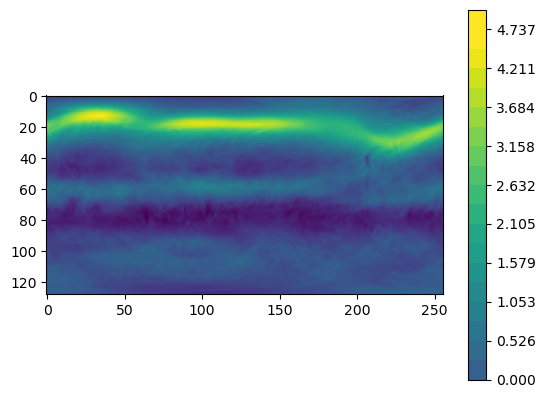

In [37]:
z_0, t_0, q_0, u_0, v_0 = x_train[:1, 0, 4:].chunk(5, dim=1)
plt.imshow(u_0[0, 0].squeeze().detach().cpu().numpy())
plt.colorbar(boundaries=np.linspace(0, 5, 20))

In [ ]:
import imageio

In [ ]:
png_dir = 'predictions/png'
images = []
for i in range(6):
    images.append(imageio.imread(f"predictions/imvp_v2_{i}.png"))


imageio.mimsave('predictions/imvp_v2.gif', images)